### Introduction

Kiva.org is a non-profit microfinancing organization - users from around the world are able to lend money to people around the world - mainly less-developed countries (LDCs). Its mission is to build a stronger middle-class for these economies.

This project requests data from Kiva.org's API and uses the data to see what industries loans are flowing into for each country. The matrix below shows an example of the results - it's interesting to see what the Kiva community is collectively doing for industries in LDCs.

#### Interpretation
*Please note that we are using a small sample size due to API call limits, therefore results may not be representative of the population.*

* Loans from Armeni and Nigeria are dominated in Agriculture
* Loans from Mexico mainly in Health
* Loans from Indonesia mainly in Housing
* Loans in Entertainment, Construction, Manufacturing and Wholesale are rare across the board
* Loans for Agriculture and Food are the most common

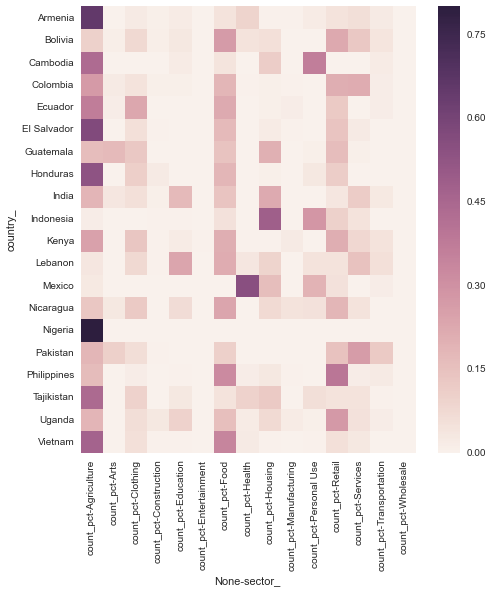

In [589]:
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(sector_by_country, vmax=.8, square=True)

In [264]:
%matplotlib inline
import numpy as np
import pandas as pd
import json, urllib
import seaborn as sns
from scipy import stats
import pdb
from collections import defaultdict
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
pages = 2000
# loans = []
for page in xrange(1, pages):
    data = urllib.urlopen('http://api.kivaws.org/v1/loans/search.json?status=fundraising&page={0}'
                          .format(page)).read()
    
    if page % 20 == 0:
        time.sleep(300)
        
    try:
        loans += json.loads(data)['loans']
    except KeyError as e:
        print '{}, {}'.format(page, e)

In [432]:
class EncodedDict(dict):
    ''' Deep-encoding of unicode key and values to ascii at initialization of dict '''
    
    def __init__(self, default={}):
        super(EncodedDict, self).__init__(default)
        self = self.__recursive_encode(self)
    
    @staticmethod
    def __recursive_encode(d):
        
        for k,v in d.iteritems():
            d.pop(k)
            if isinstance(k, unicode):
                k = k.encode('ascii', 'ignore')
            
            if isinstance(v, unicode):
                v = v.encode('ascii', 'ignore')
            elif isinstance(v, list):
                new_v = []
                for element in v:
                    if isinstance(element, dict):
                        new_v.append(EncodedDict.__recursive_encode(element))
                    elif isinstance(element, unicode):
                        new_v.append(element.encode('ascii', 'ignore'))
                v = new_v
            elif isinstance(v, dict):
                v = EncodedDict.__recursive_encode(v)

            d[k] = v
            
        return d

In [433]:
flds = map(lambda s: s.encode('ascii'), output['loans'][0].keys())
flds_set = set(flds)

dataset = defaultdict(lambda: list())
for loan in loans:
    loan = EncodedDict(loan)
    for fld in flds:
        dataset[fld].append(loan[fld] if fld in loan else None)
        if fld == 'location':
            loc = loan[fld]
            dataset['country'].append(loc['country'] if 'country' in loc else None)
            dataset['country_code'].append(loc['country_code'] if 'country_code' in loc else None)
            dataset['town'].append(loc['town'] if 'town' in loc else None)

df = pd.DataFrame()
for fld, column_data in dataset.iteritems():
    df[fld] = column_data

In [434]:
df.count()

funded_amount               10427
sector                      10427
posted_date                 10427
basket_amount               10421
planned_expiration_date     10427
image                       10427
bonus_credit_eligibility    10427
country_code                10427
partner_id                  10427
id                          10427
use                         10427
lender_count                10427
borrower_count              10427
location                    10427
status                      10427
description                 10427
tags                        10427
loan_amount                 10427
town                         9787
name                        10427
country                     10427
activity                    10427
dtype: int64

In [554]:
from collections import Counter
Counter([(sector, activity) for sector, activity in zip(df.sector, df.activity)])

Counter({('Agriculture', 'Agriculture'): 440,
         ('Agriculture', 'Animal Sales'): 275,
         ('Agriculture', 'Cattle'): 143,
         ('Agriculture', 'Dairy'): 127,
         ('Agriculture', 'Farm Supplies'): 195,
         ('Agriculture', 'Farming'): 1630,
         ('Agriculture', 'Flowers'): 16,
         ('Agriculture', 'Land Rental'): 13,
         ('Agriculture', 'Livestock'): 272,
         ('Agriculture', 'Pigs'): 317,
         ('Agriculture', 'Poultry'): 140,
         ('Arts', 'Arts'): 8,
         ('Arts', 'Crafts'): 29,
         ('Arts', 'Embroidery'): 98,
         ('Arts', 'Textiles'): 12,
         ('Arts', 'Weaving'): 19,
         ('Clothing', 'Clothing'): 42,
         ('Clothing', 'Clothing Sales'): 472,
         ('Clothing', 'Used Clothing'): 130,
         ('Clothing', 'Used Shoes'): 14,
         ('Construction', 'Bricks'): 12,
         ('Construction', 'Cement'): 1,
         ('Construction', 'Construction'): 23,
         ('Construction', 'Construction Supplies'): 13,


In [437]:
df.describe()

,funded_amount,basket_amount,bonus_credit_eligibility,partner_id,id,lender_count,borrower_count,loan_amount
count,10427.000000,10421.000000,10427,10427.000000,10427.000000,10427.000000,10427.000000,10427.000000
mean,115.620504,0.292678,0.5529874,200.055529,1073965.467344,3.730891,1.562578,850.213388
std,277.416909,19.676138,0.4972082,102.701558,4426.805894,7.844834,2.222902,827.366201
min,0.000000,0.000000,False,9.000000,1052604.000000,0.000000,1.000000,50.000000
25%,0.000000,0.000000,0,138.000000,1072465.500000,0.000000,1.000000,350.000000
50%,25.000000,0.000000,1,177.000000,1075915.000000,1.000000,1.000000,550.000000
75%,100.000000,0.000000,1,247.000000,1076974.000000,4.000000,1.000000,1000.000000
max,5500.000000,2000.000000,True,481.000000,1091413.000000,155.000000,26.000000,7900.000000


In [438]:
cat_feats = ['status', 'sector', 'activity', 'country']
num_feats = ['funded_amount', 'basket_amount', 'lender_count', 'borrower_count', 'loan_amount']

In [439]:
for feat in cat_feats:
    print '\n{0}'.format(feat)
    print df[feat].value_counts()


status
fundraising    10421
funded             6
dtype: int64

sector
Agriculture       3568
Food              1757
Retail            1728
Services           885
Clothing           658
Housing            548
Personal Use       305
Transportation     289
Education          215
Health             175
Arts               166
Manufacturing       62
Construction        62
Entertainment        6
Wholesale            3
dtype: int64

activity
Farming                      1630
General Store                 792
Personal Housing Expenses     515
Clothing Sales                472
Agriculture                   440
Food Production/Sales         405
Retail                        369
Pigs                          317
Animal Sales                  275
Livestock                     272
Tailoring                     234
Grocery Store                 219
Beauty Salon                  199
Fruits & Vegetables           198
Farm Supplies                 195
Fish Selling                  168
Food Stall       

## Filter Countries

In [455]:
# filter for countries with counts > 100
min_count = 100
mask = df['country'].value_counts() > min_count
selected_countries = set(mask.index[mask.values])
filtered_df = df[df.country.map(lambda x: x in selected_countries)]

In [585]:
groups = filtered_df[cat_feats + ['loan_amount']].groupby(by=['country', 'sector']).agg(['count', 'mean'])
country_counts = df['country'].value_counts()
groups.reset_index(inplace=True)
groups = groups[['country', 'sector', 'loan_amount']]
groups.columns = ['_'.join(col).strip() for col in groups.columns.values]

In [586]:
arr = []
for row in groups.iterrows():
    arr.append(row[1]['loan_amount_count'] / float(country_counts[[row[1]['country_']]]))
groups['count_pct'] =  arr

In [587]:
sector_by_country = groups.pivot_table(index=['country_'], columns=['sector_'], values=['count_pct'])
sector_by_country.fillna(0, inplace=True)

## Filter for Industries (Agriculture, Food, Health, Housing, Education, Retail)

In [590]:
sectors = {'Agriculture', 'Food', 'Education', 'Health', 'Retail'}
mask = map(lambda x: x in sectors, groups.sector_)
filtered_industries = groups[mask]

#### Drop all loan amount count less than 10

In [594]:
filtered_industries = filtered_industries[filtered_industries.loan_amount_count >= 10]
loan_min_mean, loan_max_mean = filtered_industries.loan_amount_mean.min(), filtered_industries.loan_amount_mean.max()

In [595]:
loan_amount_by_sector = fitered_industries.pivot_table(index=['country_'], columns=['sector_'], values=['loan_amount_mean'])
loan_amount_by_sector.fillna(0, inplace=True)
loan_amount_by_sector.reset_index(inplace=True)

In [596]:
columns = []
for column_tuples in loan_amount_by_sector.columns.values:
    columns.append(column_tuples[1] if column_tuples[1] else column_tuples[0])
loan_amount_by_sector.columns = columns
loan_amount_by_sector.set_index('country_', inplace=True)

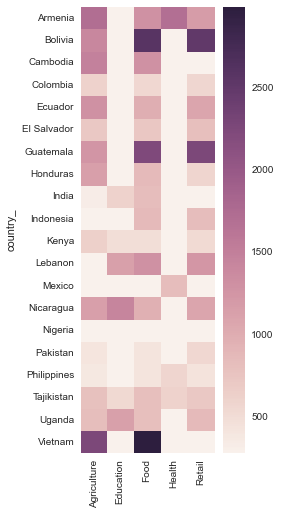

In [597]:
f, ax = plt.subplots(figsize=(3, 8))
sns.heatmap(loan_amount_by_sector, vmin=loan_min_mean, vmax=loan_max_mean)

## FIlter by Activity

In [627]:
df_agric = filtered_df[filtered_df.sector == 'Agriculture']
groups = df_agric[['country', 'activity', 'loan_amount']].groupby(by=['country', 'activity']).agg(['count'])
groups.reset_index(inplace=True)
groups.columns = ['country', 'activity', 'loan_amount_count']
loan_min_count, loan_max_count = groups.loan_amount_count.min(), groups.loan_amount_count.max()

In [646]:
count_by_activity = groups.pivot_table(index=['country'], columns=['activity'], values=['loan_amount_count'])
count_by_activity.fillna(0, inplace=True)

In [652]:
count_by_activity.columns = [x[1] for x in count_by_activity.columns.values]

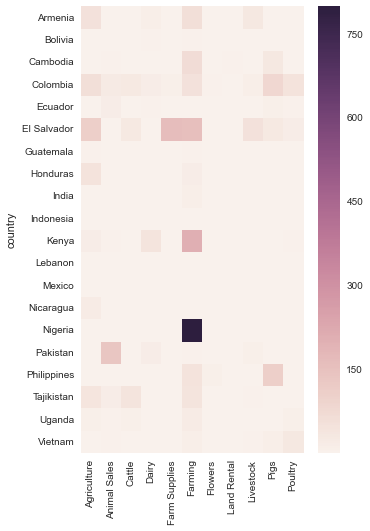

In [653]:
f, ax = plt.subplots(figsize=(5, 8))
sns.heatmap(count_by_activity, vmin=loan_min_count, vmax=loan_max_count)

* Loans from Nigeria are dominated by farming

In [658]:
count_by_activity.head()

,Agriculture,Animal Sales,Cattle,Dairy,Farm Supplies,Farming,Flowers,Land Rental,Livestock,Pigs,Poultry
country,,,,,,,,,,,
Armenia,51,0,4,11,0,60,0,0,34,2,0
Bolivia,3,3,2,6,0,5,0,0,0,0,0
Cambodia,0,5,0,0,0,68,0,5,0,35,1
Colombia,58,25,28,18,9,51,5,0,12,84,46
Ecuador,4,14,1,7,3,3,0,0,0,8,5


In [661]:
count_by_activity = count_by_activity[count_by_activity.index != 'Nigeria']

In [674]:
groups = df_agric[['country', 'activity', 'loan_amount']].groupby(by=['country', 'activity']).agg(['count'])
groups.reset_index(inplace=True)
groups.columns = ['country', 'activity', 'loan_amount_count']
groups = groups[groups.country != 'Nigeria']

loan_min_count, loan_max_count = groups.loan_amount_count.min(), groups.loan_amount_count.max()

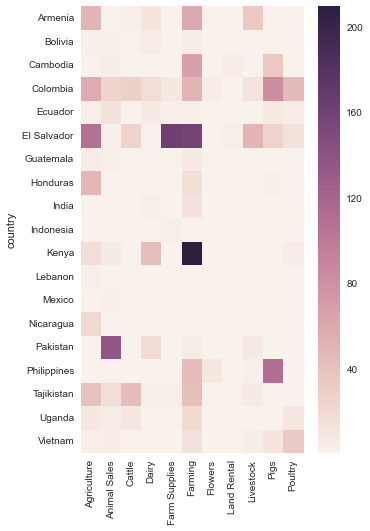

In [676]:
f, ax = plt.subplots(figsize=(5, 8))
sns.heatmap(count_by_activity, vmin=loan_min_count, vmax=loan_max_count)